# Housing Data

### To use California census data to build a model of housing prices in the state. The data includes metrics such as population, median income, and median housing price for each block group in California

In [1]:
#import libraries needed for task

import os
import tarfile
import urllib
import tensorflow as tf
from six.moves import urllib

In [2]:
#here is the function to fetch the data for task

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()
    
fetch_housing_data()

In [3]:
#now lets load the data using pandas

import pandas as pd

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

In [4]:
#taking a look at the top 5 rows of data from the file
housing = load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [5]:
#the info() method is a quick description of the data we are dealing with
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [6]:
#find out which categories exist in ocean_proximity and how many districts belong to each
housing["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [7]:
#the describe method shows a summary of the numerical attributes
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


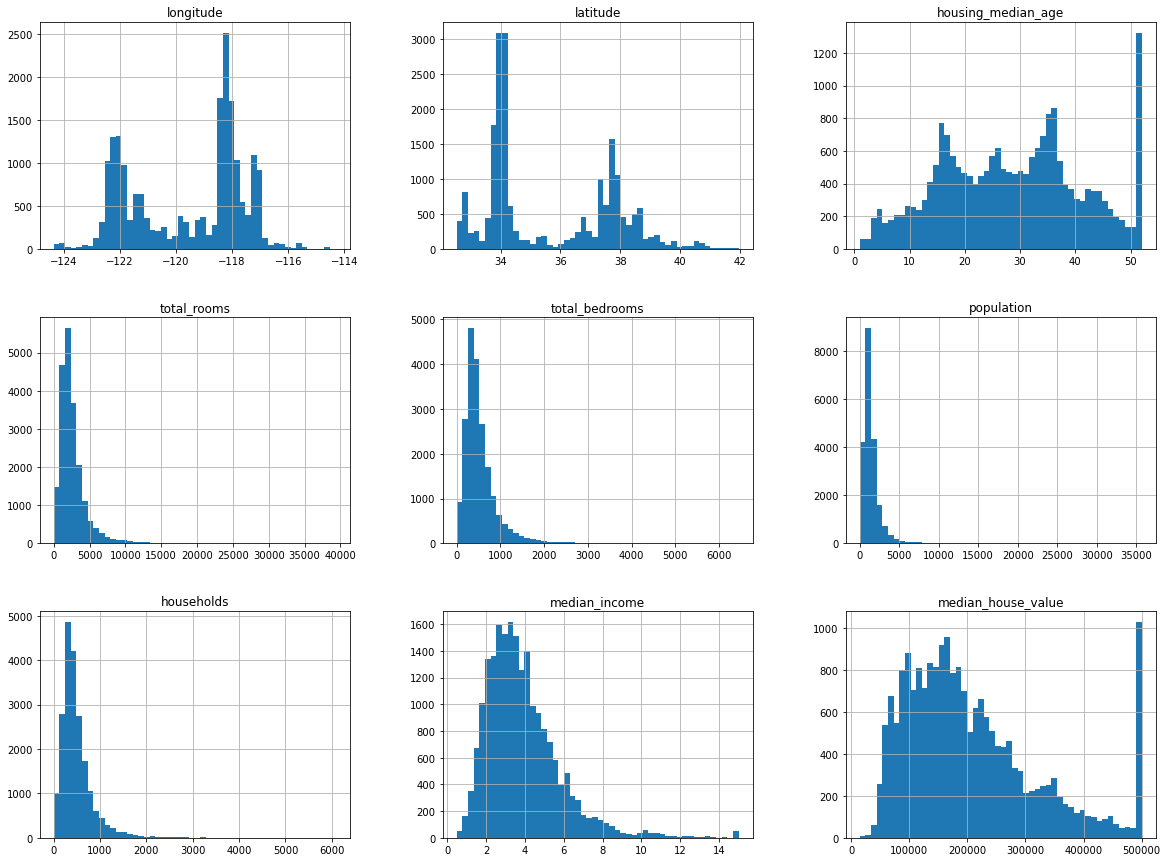

In [8]:
#plot each of the above on a histogram to visualise each numerical attribute
#next line only in jupyter notebooks
%matplotlib inline                   
import matplotlib.pyplot as plt
housing.hist(bins=50, figsize=(20,15))
plt.show()

<AxesSubplot:>

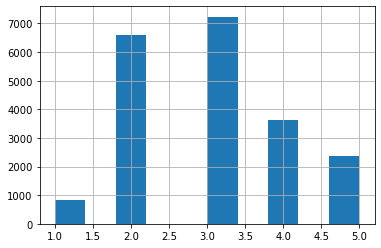

In [9]:
#looking at the median_income more closely as we have been told this is an important indicator and needs to be representive
import numpy as np
housing["income_cat"] = pd.cut(housing["median_income"], bins=[0., 1.5, 3., 4.5, 6., np.inf], labels=[1, 2, 3, 4, 5])
housing["income_cat"].hist()

## Creating the train and test sets using sk stratified shuffle split

In [10]:
#creating the train and test sets using sk stratified shuffle split
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

In [11]:
#testing to see if the cell above worked as expected in comparisson to the income_cat histogram
strat_test_set["income_cat"].value_counts() / len(strat_test_set)

3    0.350533
2    0.318798
4    0.176357
5    0.114583
1    0.039729
Name: income_cat, dtype: float64

In [12]:
#removing the income_cat attribute so the data is back to its original state
for set_ in(strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

## Discover and Visualize the Data to Gain insights

In [13]:
# create a copy of the traninig set so we can visualise it without harming the training set
housing = strat_train_set.copy()

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

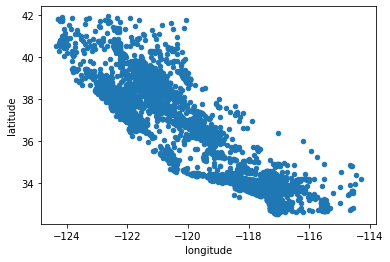

In [14]:
# using the lat and long we can create a scatterplot of all districts to visualise the data
housing.plot(kind="scatter", x="longitude", y="latitude")

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

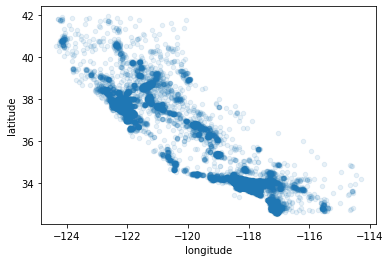

In [15]:
#setting the alpha to 0.1 makes it easier to visualise the places where there is a high density of data points
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1)

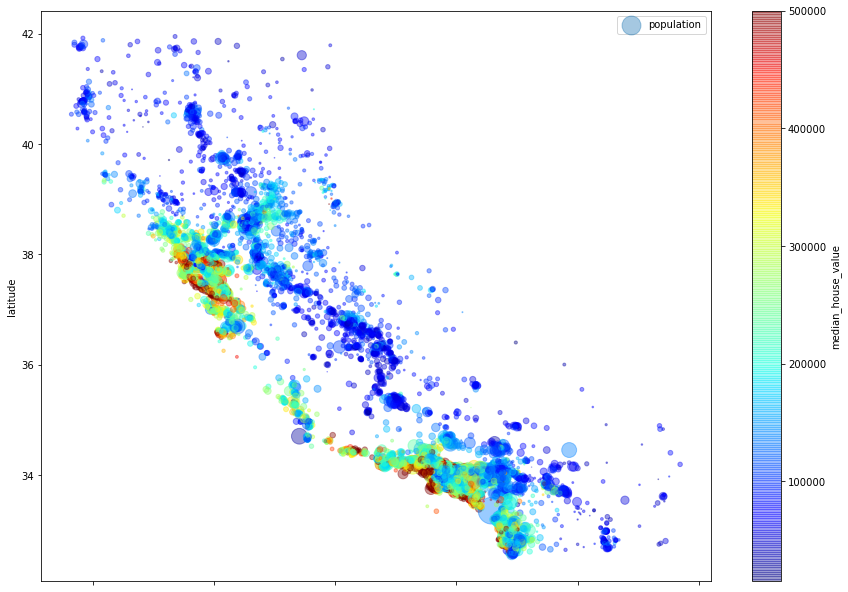

In [16]:
# now lets plot the housing price blue is low prices and red is high prices, radius of circle represents district population

housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4, s=housing["population"]/50, label="population", 
             figsize=(15,10.5), c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,)
plt.legend()

### The housing prices in the graph above are very much related to the location (eg. close to the ocean) and population density. A clustering algorithm should be used for detecting the main cluster and for adding new features that measure the proximity to the cluster centres. The ocean proximity attribute may be useful as well, although in N.California the housing prices in coastal districts are not too high, so it is not a simple rule

## Looking for Correlations

In [17]:
#pearsons r, computing every standard correlation coefficient between every pair of attributes
corr_matrix = housing.corr()

In [18]:
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

array([[<AxesSubplot:xlabel='median_house_value', ylabel='median_house_value'>,
        <AxesSubplot:xlabel='median_income', ylabel='median_house_value'>,
        <AxesSubplot:xlabel='total_rooms', ylabel='median_house_value'>,
        <AxesSubplot:xlabel='housing_median_age', ylabel='median_house_value'>],
       [<AxesSubplot:xlabel='median_house_value', ylabel='median_income'>,
        <AxesSubplot:xlabel='median_income', ylabel='median_income'>,
        <AxesSubplot:xlabel='total_rooms', ylabel='median_income'>,
        <AxesSubplot:xlabel='housing_median_age', ylabel='median_income'>],
       [<AxesSubplot:xlabel='median_house_value', ylabel='total_rooms'>,
        <AxesSubplot:xlabel='median_income', ylabel='total_rooms'>,
        <AxesSubplot:xlabel='total_rooms', ylabel='total_rooms'>,
        <AxesSubplot:xlabel='housing_median_age', ylabel='total_rooms'>],
       [<AxesSubplot:xlabel='median_house_value', ylabel='housing_median_age'>,
        <AxesSubplot:xlabel='median_incom

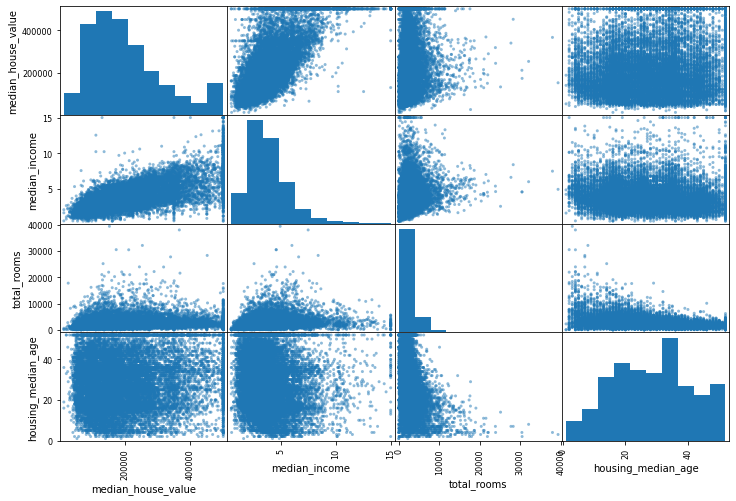

In [19]:
#Another way to check for correlation is to use pandas scatter_matrix() function which plots every numerical 
#attribute against every other numerical attribute

from pandas.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", "total_rooms", "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12,8))

### The most promising attribute to predict the median house value is the median income so lets zoom in on this one.

<AxesSubplot:xlabel='median_income', ylabel='median_house_value'>

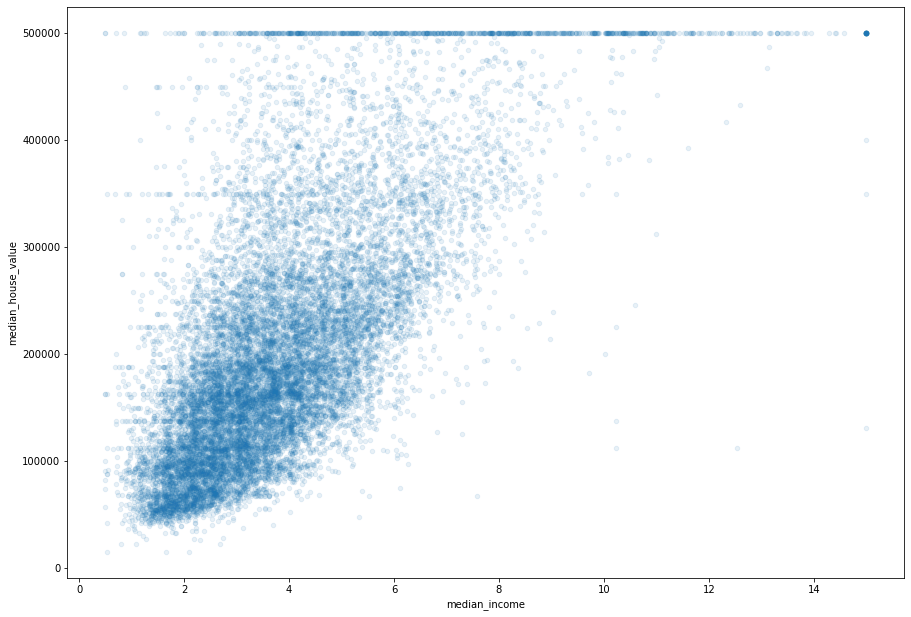

In [20]:
housing.plot(kind="scatter", x="median_income", y="median_house_value", figsize=(15,10.5), alpha=0.1)

### The points around 500,000. 450,000. 350,000. and perhaps 280,000 will need to be removed from the data to stop the model reproducing these data quirks. 500,000 is the value cap in the data which is a clear straight line at the top of the graph.

In [21]:
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"] = housing["population"]/housing["households"]

In [22]:
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687160
rooms_per_household         0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedrooms_per_room          -0.259984
Name: median_house_value, dtype: float64

## Preparing the Data for Machine Learning Algorithms

### Lets now write functions to automate the preperation of data for the reasons below
 - This will allow you to reproduce these transformation for later use (next time you get a fresh dataset)
 - Gradually build a library of transformation functions that you can reuse in future projects
 - You can use these functions ihn your live system to transform the new data before feeding it to your algorithms
 
### Now lets revert to a clean training set and seperate the predictors and the labels. Drop() creates a copy of the data and does not affect strat_train_set.

In [23]:
housing = strat_train_set.drop("median_house_value", axis = 1)
housing_labels = strat_train_set["median_house_value"].copy()

In [24]:
#taking care of the missing values in total_bedrooms

from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="median")
housing_num = housing.drop("ocean_proximity", axis=1)

#now you can fit the imputer instance to the training data using the fit() method
imputer.fit(housing_num)

SimpleImputer(strategy='median')

In [25]:
imputer.statistics_

array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
        408.    ,    3.5409])

In [26]:
housing_num.median().values

array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
        408.    ,    3.5409])

In [27]:
X = imputer.transform(housing_num)

In [28]:
housing_tr = pd.DataFrame(X, columns=housing_num.columns, index=housing_num.index)

## Handling Text and Categorical Attributes

In [29]:
housing_cat = housing[["ocean_proximity"]]
housing_cat.head(10)

,ocean_proximity
17606,<1H OCEAN
18632,<1H OCEAN
14650,NEAR OCEAN
3230,INLAND
3555,<1H OCEAN
19480,INLAND
8879,<1H OCEAN
13685,INLAND
4937,<1H OCEAN
4861,<1H OCEAN


In [30]:
#now lets convert these categories above to a number using the OneHotEncoder

from sklearn.preprocessing import OneHotEncoder
cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

In [31]:
housing_cat_1hot.toarray()

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

In [32]:
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

## Custom Transformers

### Pipelines make your life easy by pre-processing the data. Here is a small transformer class that adds the combined attributes we discussed earlier.

In [33]:
from sklearn.base import BaseEstimator, TransformerMixin

# get the right column indices: safer than hard-coding indices 3, 4, 5, 6
rooms_ix, bedrooms_ix, population_ix, household_ix = [
    list(housing.columns).index(col)
    for col in ("total_rooms", "total_bedrooms", "population", "households")]

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True): # no *args or **kwargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix] / X[:, household_ix]
        population_per_household = X[:, population_ix] / X[:, household_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,
                         bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)
    

## Transformation pipelines

In [34]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler()),
    ])

housing_num_tr = num_pipeline.fit_transform(housing_num)

In [35]:
housing_num_tr


array([[-1.15604281,  0.77194962,  0.74333089, ..., -0.31205452,
        -0.08649871,  0.15531753],
       [-1.17602483,  0.6596948 , -1.1653172 , ...,  0.21768338,
        -0.03353391, -0.83628902],
       [ 1.18684903, -1.34218285,  0.18664186, ..., -0.46531516,
        -0.09240499,  0.4222004 ],
       ...,
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.3469342 ,
        -0.03055414, -0.52177644],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.02499488,
         0.06150916, -0.30340741],
       [-1.43579109,  0.99645926,  1.85670895, ..., -0.22852947,
        -0.09586294,  0.10180567]])

In [36]:
from sklearn.compose import ColumnTransformer

num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(), cat_attribs),
    ])
housing_prepared = full_pipeline.fit_transform(housing)

In [37]:
housing_prepared

array([[-1.15604281,  0.77194962,  0.74333089, ...,  0.        ,
         0.        ,  0.        ],
       [-1.17602483,  0.6596948 , -1.1653172 , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.18684903, -1.34218285,  0.18664186, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.        ,
         0.        ,  0.        ],
       [-1.43579109,  0.99645926,  1.85670895, ...,  0.        ,
         1.        ,  0.        ]])

## Select and Train a Model

### First lets use a linear regression model 

In [38]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression()

In [39]:
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)
print("Predictions: ", lin_reg.predict(some_data_prepared))
print("Labels: ", list(some_labels))

Predictions:  [210644.60459286 317768.80697211 210956.43331178  59218.98886849
 189747.55849879]
Labels:  [286600.0, 340600.0, 196900.0, 46300.0, 254500.0]


### It works although the predictions arent very accurate, the first prediction is off by almost 40%!
### Now lets try RMSE

In [40]:
from sklearn.metrics import mean_squared_error

housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

68628.19819848923

### This value is better than nothing but clearly not a great score, most districts median_housing_values range between 120,000 and 265,000 so a typical prediction error of 68,628 is not very satisfying. This is an example of underfitting the training data, when this happens it can mean that the features do not provide enough info to make good predicitions, or the model is not powerful enough.

### Lets now try a decision tree model

In [41]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)

DecisionTreeRegressor()

In [42]:
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

### It is more likely that the model has badly overfit the data. we need to use part of the training set for training and part of it for model validation.



## Better Evaluation Using Cross-Validation

### One way to evaluate would be to use the train_test_split() function to split the raining set into a smaller training set and evaluate them against the validation set, its a bit of work but would work fairly well.

### A great alternative is to use scikits kfold cross validation feature. the following code randomly splits the training set into 10 distinct subsets called folds, then it trains and evaluates the decision tree 10 times picking a different fold for evaluation every time and training on the other 9 folds. the result is an array containing the 10 evaluation scores:

In [43]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(tree_reg, housing_prepared, housing_labels,
                        scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

In [44]:
#lets look at the results

def display_scores(scores):
    print("Scores: ", scores)
    print("Mean: ", scores.mean())
    print("Standard deviation: ", scores.std())
    
display_scores(tree_rmse_scores)

Scores:  [69084.50003226 65241.03980147 71582.22808679 68442.53037624
 69996.08623078 75513.87160817 69748.99050247 70235.67389084
 76387.5138242  69200.92996381]
Mean:  70543.33643170474
Standard deviation:  3121.266475107782


### As expected the decision tree model is overfitting so badly that it performs worse than the linear regression model.

### lets try one last model RandomForestRegressor. random forests work by training many decision trees on random subsets of the features then averaging out their predictions. Building a model on top of many other models is called ensemble learning and it is often a good way of pushing ML models further.

In [45]:
from sklearn.ensemble import RandomForestRegressor
forest_reg = RandomForestRegressor()
forest_reg.fit(housing_prepared, housing_labels)

housing_predictions = forest_reg.predict(housing_prepared)
forest_mse = mean_squared_error(housing_labels, housing_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

18674.102956973693

In [46]:
from sklearn.model_selection import cross_val_score

forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels,
                                scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

Scores:  [49581.15361772 47832.35181755 49931.70734045 52304.8467605
 49792.91185258 53576.21676488 48799.62573416 47905.88025293
 53060.05608239 49782.09065175]
Mean:  50256.68408749248
Standard deviation:  1939.126650290132


## Grid Search

### GridSearchCV searches hyparameters to tune for you or else doing it manually would be very tedious work


In [50]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    # try 12 (3×4) combinations of hyperparameters
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    # then try 6 (2×3) combinations with bootstrap set as False
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
  ]

forest_reg = RandomForestRegressor(random_state=42)
# train across 5 folds, that's a total of (12+6)*5=90 rounds of training 
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error', return_train_score=True)
grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 30]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [51]:
grid_search.best_params_

{'max_features': 8, 'n_estimators': 30}

In [53]:
grid_search.best_estimator_

RandomForestRegressor(max_features=8, n_estimators=30, random_state=42)

In [54]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

63669.11631261028 {'max_features': 2, 'n_estimators': 3}
55627.099719926795 {'max_features': 2, 'n_estimators': 10}
53384.57275149205 {'max_features': 2, 'n_estimators': 30}
60965.950449450494 {'max_features': 4, 'n_estimators': 3}
52741.04704299915 {'max_features': 4, 'n_estimators': 10}
50377.40461678399 {'max_features': 4, 'n_estimators': 30}
58663.93866579625 {'max_features': 6, 'n_estimators': 3}
52006.19873526564 {'max_features': 6, 'n_estimators': 10}
50146.51167415009 {'max_features': 6, 'n_estimators': 30}
57869.25276169646 {'max_features': 8, 'n_estimators': 3}
51711.127883959234 {'max_features': 8, 'n_estimators': 10}
49682.273345071546 {'max_features': 8, 'n_estimators': 30}
62895.06951262424 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
54658.176157539405 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
59470.40652318466 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
52724.9822587892 {'bootstrap': False, 'max_features': 3, 'n_estimators'

In [55]:

pd.DataFrame(grid_search.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_features,param_n_estimators,param_bootstrap,params,split0_test_score,split1_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.063230,0.011346,0.003397,4.840369e-04,2,3,NaN,"{'max_features': 2, 'n_estimators': 3}",-3.837622e+09,-4.147108e+09,...,-4.053756e+09,1.519591e+08,18,-1.064113e+09,-1.105142e+09,-1.116550e+09,-1.112342e+09,-1.129650e+09,-1.105559e+09,2.220402e+07
1,0.188899,0.001199,0.008573,4.849557e-04,2,10,NaN,"{'max_features': 2, 'n_estimators': 10}",-3.047771e+09,-3.254861e+09,...,-3.094374e+09,1.327062e+08,11,-5.927175e+08,-5.870952e+08,-5.776964e+08,-5.716332e+08,-5.802501e+08,-5.818785e+08,7.345821e+06
2,0.560900,0.004950,0.024940,7.811111e-06,2,30,NaN,"{'max_features': 2, 'n_estimators': 30}",-2.689185e+09,-3.021086e+09,...,-2.849913e+09,1.626875e+08,9,-4.381089e+08,-4.391272e+08,-4.371702e+08,-4.376955e+08,-4.452654e+08,-4.394734e+08,2.966320e+06
3,0.089557,0.001170,0.002793,3.968484e-04,4,3,NaN,"{'max_features': 4, 'n_estimators': 3}",-3.730181e+09,-3.786886e+09,...,-3.716847e+09,1.631510e+08,16,-9.865163e+08,-1.012565e+09,-9.169425e+08,-1.037400e+09,-9.707739e+08,-9.848396e+08,4.084607e+07
4,0.293605,0.002417,0.008584,4.944289e-04,4,10,NaN,"{'max_features': 4, 'n_estimators': 10}",-2.666283e+09,-2.784511e+09,...,-2.781618e+09,1.268607e+08,8,-5.097115e+08,-5.162820e+08,-4.962893e+08,-5.436192e+08,-5.160297e+08,-5.163863e+08,1.542862e+07
5,0.878456,0.002929,0.025139,1.463606e-03,4,30,NaN,"{'max_features': 4, 'n_estimators': 30}",-2.387153e+09,-2.588448e+09,...,-2.537883e+09,1.214614e+08,3,-3.838835e+08,-3.880268e+08,-3.790867e+08,-4.040957e+08,-3.845520e+08,-3.879289e+08,8.571233e+06
6,0.121674,0.004325,0.002993,9.536743e-08,6,3,NaN,"{'max_features': 6, 'n_estimators': 3}",-3.119657e+09,-3.586319e+09,...,-3.441458e+09,1.893056e+08,14,-9.245343e+08,-8.886939e+08,-9.353135e+08,-9.009801e+08,-8.624664e+08,-9.023976e+08,2.591445e+07
7,0.400129,0.002985,0.008382,4.859387e-04,6,10,NaN,"{'max_features': 6, 'n_estimators': 10}",-2.549663e+09,-2.782039e+09,...,-2.704645e+09,1.471569e+08,6,-4.980344e+08,-5.045869e+08,-4.994664e+08,-4.990325e+08,-5.055542e+08,-5.013349e+08,3.100456e+06
8,1.202582,0.004820,0.024934,6.309025e-04,6,30,NaN,"{'max_features': 6, 'n_estimators': 30}",-2.370010e+09,-2.583638e+09,...,-2.514673e+09,1.285080e+08,2,-3.838538e+08,-3.804711e+08,-3.805218e+08,-3.856095e+08,-3.901917e+08,-3.841296e+08,3.617057e+06
9,0.151794,0.001716,0.002992,9.536743e-08,8,3,NaN,"{'max_features': 8, 'n_estimators': 3}",-3.353504e+09,-3.348552e+09,...,-3.348850e+09,1.241939e+08,13,-9.228123e+08,-8.553031e+08,-8.603321e+08,-8.881964e+08,-9.151287e+08,-8.883545e+08,2.750227e+07


In [56]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {
        'n_estimators': randint(low=1, high=200),
        'max_features': randint(low=1, high=8),
    }

forest_reg = RandomForestRegressor(random_state=42)
rnd_search = RandomizedSearchCV(forest_reg, param_distributions=param_distribs,
                                n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=42)
rnd_search.fit(housing_prepared, housing_labels)

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
                   param_distributions={'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000018B10192208>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000018B10192948>},
                   random_state=42, scoring='neg_mean_squared_error')

In [57]:
cvres = rnd_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

49150.70756927707 {'max_features': 7, 'n_estimators': 180}
51389.889203389284 {'max_features': 5, 'n_estimators': 15}
50796.155224308866 {'max_features': 3, 'n_estimators': 72}
50835.13360315349 {'max_features': 5, 'n_estimators': 21}
49280.9449827171 {'max_features': 7, 'n_estimators': 122}
50774.90662363929 {'max_features': 3, 'n_estimators': 75}
50682.78888164288 {'max_features': 3, 'n_estimators': 88}
49608.99608105296 {'max_features': 5, 'n_estimators': 100}
50473.61930350219 {'max_features': 3, 'n_estimators': 150}
64429.84143294435 {'max_features': 5, 'n_estimators': 2}


In [58]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([7.33442355e-02, 6.29090705e-02, 4.11437985e-02, 1.46726854e-02,
       1.41064835e-02, 1.48742809e-02, 1.42575993e-02, 3.66158981e-01,
       5.64191792e-02, 1.08792957e-01, 5.33510773e-02, 1.03114883e-02,
       1.64780994e-01, 6.02803867e-05, 1.96041560e-03, 2.85647464e-03])

In [59]:
extra_attribs = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]
#cat_encoder = cat_pipeline.named_steps["cat_encoder"] # old solution
cat_encoder = full_pipeline.named_transformers_["cat"]
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse=True)

[(0.36615898061813423, 'median_income'),
 (0.16478099356159054, 'INLAND'),
 (0.10879295677551575, 'pop_per_hhold'),
 (0.07334423551601243, 'longitude'),
 (0.06290907048262032, 'latitude'),
 (0.056419179181954014, 'rooms_per_hhold'),
 (0.053351077347675815, 'bedrooms_per_room'),
 (0.04114379847872964, 'housing_median_age'),
 (0.014874280890402769, 'population'),
 (0.014672685420543239, 'total_rooms'),
 (0.014257599323407808, 'households'),
 (0.014106483453584104, 'total_bedrooms'),
 (0.010311488326303788, '<1H OCEAN'),
 (0.0028564746373201584, 'NEAR OCEAN'),
 (0.0019604155994780706, 'NEAR BAY'),
 (6.0280386727366e-05, 'ISLAND')]

## Evaluate Your System on the Test set

In [60]:
final_model = grid_search.best_estimator_

X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

X_test_prepared = full_pipeline.transform(X_test)
final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)

In [61]:
final_rmse

47730.22690385927

In [62]:
from scipy import stats

confidence = 0.95
squared_errors = (final_predictions - y_test) ** 2
mean = squared_errors.mean()
m = len(squared_errors)

np.sqrt(stats.t.interval(confidence, m - 1,
                         loc=np.mean(squared_errors),
                         scale=stats.sem(squared_errors)))

array([45685.10470776, 49691.25001878])

In [63]:
full_pipeline_with_predictor = Pipeline([
        ("preparation", full_pipeline),
        ("linear", LinearRegression())
    ])

full_pipeline_with_predictor.fit(housing, housing_labels)
full_pipeline_with_predictor.predict(some_data)

array([210644.60459286, 317768.80697211, 210956.43331178,  59218.98886849,
       189747.55849879])

In [64]:
my_model = full_pipeline_with_predictor

In [65]:
#from sklearn.externals import joblib # deprecated, use import joblib instead
import joblib

joblib.dump(my_model, "my_model.pkl") # DIFF
#...
my_model_loaded = joblib.load("my_model.pkl") # DIFF